In [1]:
import torch
import numpy as np
import pandas as pd
import pickle
import copy
from tqdm import trange,tqdm
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, classification_report, confusion_matrix

In [2]:
DRIVE = "drive/MyDrive/Colab Notebooks/ELTE/DSLAB/dataset/"
DATASET = DRIVE + "MBD.csv"
TOPOLOGY = DRIVE + "MBD_topology.pk"
NUM_OF_COMPONENTS = 5

data = pd.read_csv(DATASET, header=[0,1])
true_anomalies = data['label'].values

metric = data.drop(['date', 'label'], axis = 1)
metric.columns.names = ['host','metric']
tempm = metric.swaplevel('metric','host',axis=1).stack()
tempm = (tempm-tempm.mean())/(tempm.std())
metric = tempm.unstack().swaplevel('metric','host',axis=1).stack().unstack()
metric_tensor = torch.tensor(metric.values, dtype=torch.float32)

with open(TOPOLOGY, 'rb') as f:
    edge_index = pickle.load(f)

<ipython-input-2-49ccc0f6c925>:9: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  metric = data.drop(['date', 'label'], axis = 1)
<ipython-input-2-49ccc0f6c925>:11: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  tempm = metric.swaplevel('metric','host',axis=1).stack()
<ipython-input-2-49ccc0f6c925>:13: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  metric = tempm.unstack().swaplevel('metric','host',axis=1).stack().unstack()


In [ ]:
metric

host              R740-3-1                                               \
metric cpu.mean_usage_idle cpu.mean_usage_iowait cpu.mean_usage_softirq   
0                 1.297715             -0.632874              -0.703865   
1                 1.386064             -0.747534              -0.703948   
2                -1.239377             -0.797039              -0.664087   
3                -1.644451             -0.835336              -0.703936   
4                -1.643598             -0.838276              -0.703845   
...                    ...                   ...                    ...   
8635              1.438887             -0.821302              -0.703730   
8636              1.451945             -0.836429              -0.695918   
8637              1.440971             -0.827184              -0.672011   
8638              1.437342             -0.821685              -0.664070   
8639              1.451885             -0.833846              -0.743528   

host                                                                     \
metric cpu.mean_usage_system cpu.mean_usage_user disk.mean_used_percent   
0                  -0.812009           -0.960151              -1.912235   
1                  -0.834344           -0.958793              -1.912233   
2                  -0.693319            2.380106              -1.912231   
3                  -0.719389            2.927902              -1.912229   
4                  -0.687902            2.928635              -1.912227   
...                      ...                 ...                    ...   
8635               -0.792337           -0.955754              -1.911606   
8636               -0.784464           -0.956904              -1.911604   
8637               -0.832834           -0.950063              -1.911602   
8638               -0.765072           -0.954403              -1.911601   
8639               -0.800240           -0.958342              -1.911599   

host                                                                  \
metric diskio.io_time diskio.mean_iops_in_progress diskio.read_speed   
0           -0.125818                    -0.394307         -0.484756   
1           -0.149738                    -0.426539         -0.484756   
2           -0.137616                    -0.426539         -0.483687   
3           -0.146556                    -0.422957         -0.484743   
4           -0.174985                    -0.412214         -0.484756   
...               ...                          ...               ...   
8635        -0.226616                    -0.462351         -0.484756   
8636        -0.233937                    -0.462351         -0.484756   
8637        -0.230273                    -0.462351         -0.484756   
8638        -0.235003                    -0.462351         -0.484756   
8639        -0.232342                    -0.462351         -0.484756   

host                       ...      R740-3-5                         \
metric diskio.write_speed  ... mem.mean_free net.recieved  net.sent   
0               -0.549166  ...     -0.600163    -0.729554  0.131946   
1               -0.549179  ...     -0.496413    -0.729449  0.131897   
2               -0.549084  ...     -0.499616    -0.728573  0.131962   
3               -0.548879  ...     -0.503554    -0.727601  0.957520   
4               -0.549193  ...     -0.552925    -0.730687  0.133904   
...                   ...  ...           ...          ...       ...   
8635            -0.549426  ...     -0.640990     0.278332 -0.135095   
8636            -0.549877  ...     -0.642823     0.020555 -0.657424   
8637            -0.549508  ...     -0.625552     0.441609  0.009106   
8638            -0.548154  ...     -0.654699    -0.484553  0.898695   
8639            -0.549357  ...     -0.663206    -0.728644  0.732069   

host                                                      \
metric netstat.mean_tcp_time_wait processes.mean_blocked   
0                        3.001606               0.021189   
1      

# Algorithm utils

In [3]:
import abc
import logging
import random

import numpy as np
import torch
from torch.autograd import Variable

class Algorithm(metaclass=abc.ABCMeta):
    def __init__(self, module_name, name, seed, details=False):
        self.logger = logging.getLogger(module_name)
        self.name = name
        self.seed = seed
        self.details = details
        self.prediction_details = {}

        if self.seed is not None:
            random.seed(seed)
            np.random.seed(seed)

    def __str__(self):
        return self.name

    @abc.abstractmethod
    def fit(self, X):
        """
        Train the algorithm on the given dataset
        """

    @abc.abstractmethod
    def predict(self, X):
        """
        :return anomaly score
        """


class PyTorchUtils(metaclass=abc.ABCMeta):
    def __init__(self, seed, gpu):
        self.gpu = gpu
        self.seed = seed
        if self.seed is not None:
            torch.manual_seed(self.seed)
            torch.cuda.manual_seed(self.seed)
        self.framework = 0

    @property
    def device(self):
        return torch.device(f'cuda:{self.gpu}' if torch.cuda.is_available() and self.gpu is not None else 'cpu')

    def to_var(self, t, **kwargs):
        # ToDo: check whether cuda Variable.
        t = t.to(self.device)
        return Variable(t, **kwargs)

    def to_device(self, model):
        model.to(self.device)

# Graph LSTM

In [4]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.8 MB/s eta 0:00:00


In [5]:
import torch.nn as nn
from torch.autograd import Variable
import torch
from torch_geometric.nn import GCNConv, GATConv, GraphConv
import torch.nn.functional as F
from torch_geometric.data import Data, Batch

class GCNLSTMCell(nn.Module, PyTorchUtils):

    def __init__(self, nodes_num, input_dim, hidden_dim, bias=True, seed: int=0, gpu: int=None):
        """
        Initialize GCNLSTM cell.

        Parameters
        ----------
        nodes_num: input
            Number of nodes.
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        bias: bool
            Whether or not to add the bias.
        """

        super(GCNLSTMCell, self).__init__()
        PyTorchUtils.__init__(self, seed, gpu)

        self.nodes_num = nodes_num
        self.input_dim  = input_dim
        self.hidden_dim = hidden_dim

        self.bias = bias

        self.gconv = GCNConv(in_channels=self.input_dim + self.hidden_dim,
                             out_channels=4 * self.hidden_dim,
                             bias=self.bias,
                             improved = True)

    def forward(self, input_tensor, cur_state, edge_index):
        '''
        input_tensor:(b,n,i)
        cur_state:[(b,n,h),(b,n,h)]
        '''
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=2)  # concatenate along hidden axis
        batch = Batch.from_data_list([Data(x=combined[i], edge_index=edge_index) for i in range(combined.shape[0])])

        combined_conv = self.gconv(batch.x, batch.edge_index)
        combined_conv = combined_conv.reshape(combined.shape[0],combined.shape[1],-1)

        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=2)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        # output: (b,n,h),(b,n,h)
        return h_next, c_next

    def init_hidden(self, batch_size):
        return (self.to_var(Variable(torch.zeros(batch_size, self.nodes_num, self.hidden_dim))),
                self.to_var(Variable(torch.zeros(batch_size, self.nodes_num, self.hidden_dim))))

class GATLSTMCell(nn.Module, PyTorchUtils):

    def __init__(self, nodes_num, input_dim, hidden_dim, head=1, dropout=0, bias=True, seed: int=0, gpu: int=None):
        """
        Initialize GCNLSTM cell.

        Parameters
        ----------
        nodes_num: input
            Number of nodes.
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        head: int
            Number of multi-head-attentions.
        dropout: float
            Dropout probability of the normalized attention coefficients.
        bias: bool
            Whether or not to add the bias.
        """

        super(GATLSTMCell, self).__init__()
        PyTorchUtils.__init__(self, seed, gpu)

        self.nodes_num = nodes_num
        self.input_dim  = input_dim
        self.hidden_dim = hidden_dim
        self.head = head
        self.dropout = dropout
        self.bias = bias

        self.gconv = GATConv(in_channels=self.input_dim + self.hidden_dim,
                             out_channels=4 * self.hidden_dim,
                             heads=self.head,
                             concat = False,
                             dropout=self.dropout,
                             bias=self.bias)

    def forward(self, input_tensor, cur_state, edge_index):
        '''
        input_tensor:(b,n,i)
        cur_state:[(b,n,h),(b,n,h)]
        '''
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=2)  # concatenate along hidden axis
        batch = Batch.from_data_list([Data(x=combined[i], edge_index=edge_index) for i in range(combined.shape[0])])

        combined_conv = self.gconv(batch.x, batch.edge_index)
        combined_conv = combined_conv.reshape(combined.shape[0],combined.shape[1],-1)

        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=2)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        # output: (b,n,h),(b,n,h)
        return h_next, c_next

    def init_hidden(self, batch_size):
        return (self.to_var(Variable(torch.zeros(batch_size, self.nodes_num, self.hidden_dim))),
                self.to_var(Variable(torch.zeros(batch_size, self.nodes_num, self.hidden_dim))))

class WL1LSTMCell(nn.Module, PyTorchUtils):

    def __init__(self, nodes_num, input_dim, hidden_dim, bias=True, seed: int=0, gpu: int=None):
        """
        Initialize GCNLSTM cell.

        Parameters
        ----------
        nodes_num: input
            Number of nodes.
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        bias: bool
            Whether or not to add the bias.
        """

        super(WL1LSTMCell, self).__init__()
        PyTorchUtils.__init__(self, seed, gpu)

        self.nodes_num = nodes_num
        self.input_dim  = input_dim
        self.hidden_dim = hidden_dim

        self.bias = bias

        self.gconv = GraphConv(in_channels=self.input_dim + self.hidden_dim,
                               out_channels=4 * self.hidden_dim,
                               aggr = 'mean',
                               bias=self.bias)

    def forward(self, input_tensor, cur_state, edge_index):
        '''
        input_tensor:(b,n,i)
        cur_state:[(b,n,h),(b,n,h)]
        '''
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=2)  # concatenate along hidden axis
        batch = Batch.from_data_list([Data(x=combined[i], edge_index=edge_index) for i in range(combined.shape[0])])

        combined_conv = self.gconv(batch.x, batch.edge_index)
        combined_conv = combined_conv.reshape(combined.shape[0],combined.shape[1],-1)

        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=2)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        # output: (b,n,h),(b,n,h)
        return h_next, c_next

    def init_hidden(self, batch_size):
        return (self.to_var(Variable(torch.zeros(batch_size, self.nodes_num, self.hidden_dim))),
                self.to_var(Variable(torch.zeros(batch_size, self.nodes_num, self.hidden_dim))))

class LSTMCell(nn.Module, PyTorchUtils):

    def __init__(self, nodes_num, input_dim, hidden_dim, bias=True, seed: int=0, gpu: int=None):
        """
        Initialize GCNLSTM cell.

        Parameters
        ----------
        nodes_num: input
            Number of nodes.
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        bias: bool
            Whether or not to add the bias.
        """

        super(LSTMCell, self).__init__()
        PyTorchUtils.__init__(self, seed, gpu)

        self.nodes_num = nodes_num
        self.input_dim  = input_dim
        self.hidden_dim = hidden_dim

        self.bias = bias

        self.gconv = nn.Linear(self.input_dim + self.hidden_dim,
                               4 * self.hidden_dim,
                               bias=self.bias)

    def forward(self, input_tensor, cur_state, edge_index):
        '''
        input_tensor:(b,n,i)
        cur_state:[(b,n,h),(b,n,h)]
        '''
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=2)  # concatenate along hidden axis
        #batch = Batch.from_data_list([Data(x=combined[i], edge_index=edge_index) for i in range(combined.shape[0])])

        combined_conv = self.gconv(combined)
        #combined_conv = combined_conv.reshape(combined.shape[0],combined.shape[1],-1)

        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=2)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        # output: (b,n,h),(b,n,h)
        return h_next, c_next

    def init_hidden(self, batch_size):
        return (self.to_var(Variable(torch.zeros(batch_size, self.nodes_num, self.hidden_dim))),
                self.to_var(Variable(torch.zeros(batch_size, self.nodes_num, self.hidden_dim))))

class GraphLSTM(nn.Module, PyTorchUtils):

    def __init__(self, nodes_num, input_dim, hidden_dim, num_layers, head=1, dropout=0, kind='GCN',
                 batch_first=False, bias=True, return_all_layers=True, seed: int=0, gpu: int=None):
        super(GraphLSTM, self).__init__()
        PyTorchUtils.__init__(self, seed, gpu)

        # Make sure that `hidden_dim` are lists having len == num_layers
        hidden_dim  = self._extend_for_multilayer(hidden_dim, num_layers)
        head = self._extend_for_multilayer(head, num_layers)
        if not len(hidden_dim) == len(head) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.nodes_num = nodes_num
        self.input_dim  = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.head = head
        self.dropout = dropout
        self.kind = kind
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i-1]

            if self.kind == 'GCN':
                cell_list.append(GCNLSTMCell(nodes_num=nodes_num,
                                             input_dim=cur_input_dim,
                                             hidden_dim=self.hidden_dim[i],
                                             bias=self.bias,
                                             seed=self.seed,
                                             gpu=self.gpu))
            elif self.kind == 'GAT':
                cell_list.append(GATLSTMCell(nodes_num=nodes_num,
                                             input_dim=cur_input_dim,
                                             hidden_dim=self.hidden_dim[i],
                                             head=self.head[i],
                                             dropout=self.dropout,
                                             bias=self.bias,
                                             seed=self.seed,
                                             gpu=self.gpu))
            elif self.kind == 'WL1':
                cell_list.append(WL1LSTMCell(nodes_num=nodes_num,
                                             input_dim=cur_input_dim,
                                             hidden_dim=self.hidden_dim[i],
                                             bias=self.bias,
                                             seed=self.seed,
                                             gpu=self.gpu))
            elif self.kind == 'LIN':
                cell_list.append(LSTMCell(nodes_num=nodes_num,
                                          input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          bias=self.bias,
                                          seed=self.seed,
                                          gpu=self.gpu))
            else:
                raise NotImplementedError()

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, edge_index, hidden_state=None):
        """

        Parameters
        ----------
        input_tensor: 4-D Tensor either of shape (t, b, n, h) or (b, t, n, h)
        hidden_state: list [[(b, n, h), (b, n, h)]] * num_layers

        Returns
        -------
        last_output_list: [(b, t, n, h)] * num_layers(also determined by return_all_layers),
        layer_state_list: [[(b, n, h), (b, n, h)]] * num_layers(also determined by return_all_layers)
        """
        #确保(t, b, n, c)
        #if self.batch_first:
        #写在前面了
            # (b, t, n, c) -> (t, b, n, c)
            #input_tensor = input_tensor.permute(1, 0, 2, 3).contiguous()

        # Implement stateful GraphLSTM
        if hidden_state is not None:
            hidden_state = hidden_state
        else:
            # [[(b, n, h), (b, n, h)]] * num_layers
            hidden_state = self._init_hidden(input_tensor.size(1))

        layer_output_list = []
        last_state_list   = []

        seq_len = input_tensor.size(0)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):

            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):

                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[t],
                                                 edge_index = edge_index, cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=0)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list   = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size))
        return init_states

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param

# Graph LSTM VAE

In [6]:
import logging

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm import trange
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.data import Data, Batch
from torch.nn.init import xavier_normal_, zeros_

class GraphLSTM_VAE(nn.Module, PyTorchUtils):
    def __init__(self, nodes_num: int, input_dim: int, hidden_dim: int,
                 num_layers: tuple=(2,2), head: tuple=(1,1), dropout: tuple=(0,0), kind: str='GCN',
                 batch_first: bool=True, bias: tuple=(True, True), variational: bool=True, seed: int=0, gpu: int=None):
        super().__init__()
        PyTorchUtils.__init__(self, seed, gpu)
        self.nodes_num = nodes_num
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.num_layers = num_layers
        self.head = head
        self.dropout = dropout
        self.kind = kind
        self.batch_first = batch_first
        self.bias = bias
        self.variational = variational

        self.encoder = GraphLSTM(self.nodes_num, self.input_dim, self.hidden_dim,
                                 num_layers = self.num_layers[0], head = self.head[0],
                                 dropout=self.dropout[0], kind = self.kind,
                                 batch_first = self.batch_first, bias=self.bias[0],
                                 seed = self.seed, gpu = self.gpu)
        self.to_device(self.encoder)
        self.decoder = GraphLSTM(self.nodes_num, self.input_dim, self.hidden_dim,
                                 num_layers = self.num_layers[1], head = self.head[1],
                                 dropout=self.dropout[1], kind = self.kind,
                                 batch_first = self.batch_first, bias=self.bias[1],
                                 seed = self.seed, gpu = self.gpu)
        self.to_device(self.decoder)
        if self.variational == True:
            self.mu = nn.ModuleList([nn.Linear(self.hidden_dim,
                                self.hidden_dim,
                                bias=self.bias[1]) for i in range(self.nodes_num)])
            self.logvar = nn.ModuleList([nn.Linear(self.hidden_dim,
                                    self.hidden_dim,
                                    bias=self.bias[1]) for i in range(self.nodes_num)])
            self.hidden2output_logvar = nn.ModuleList([nn.Linear(self.hidden_dim,
                                                  self.input_dim,
                                                  bias=self.bias[1]) for i in range(self.nodes_num)])
        self.hidden2output = nn.ModuleList([nn.Linear(self.hidden_dim,
                                       self.input_dim,
                                       bias=self.bias[1]) for i in range(self.nodes_num)])

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, GCNConv) or isinstance(m, GATConv):
                xavier_normal_(m.weight)
                if m.bias is not None:
                    zeros_(m.bias)

    def reparametrize(self, mu, logvar):
        return mu + torch.randn_like(logvar) * torch.exp(logvar)

    def deal_batch(self, conv, x, edge_index):
        batch = Batch.from_data_list([Data(x=x[i], edge_index=edge_index) for i in range(x.shape[0])])

        output = conv(batch.x, batch.edge_index)
        output = output.reshape(x.shape[0],x.shape[1],-1)

        return output

    def deal_list(self, module_list, x):
        x = x.permute(1, 0, 2).contiguous()
        outputs = []
        for i,l in enumerate(module_list):
            output = l(x[i])
            outputs.append(output)
        return torch.stack(outputs, 1)

    def forward(self, ts_batch, edge_index, use_teacher_forcing = True):
        if self.batch_first:
            # (b, t, n, c) -> (t, b, n, c)
            ts_batch = ts_batch.permute(1, 0, 2, 3).contiguous()

        # 1. Encode the timeseries to make use of the last hidden state.
        _, enc_hidden0 = self.encoder(ts_batch.float(), edge_index)  # .float() here or .double() for the model

        enc_hidden = enc_hidden0[-1][0]
        # 2. Use hidden state as initialization for our Decoder-LSTM
        if self.variational:
            mu = self.deal_list(self.mu, enc_hidden)#self.mu(enc_hidden)#self.deal_batch(self.mu, enc_hidden, edge_index)#self.mu(enc_hidden, edge_index)
            logvar = self.deal_list(self.logvar, enc_hidden)#self.logvar(enc_hidden)#self.deal_batch(self.logvar, enc_hidden, edge_index)#self.logvar(enc_hidden, edge_index)
            enc_hidden = self.reparametrize(mu, logvar)

        dec_hidden = enc_hidden0
        #print(dec_hidden[0][0].size())

        # 3. Also, use this hidden state to get the first output aka the last point of the reconstructed timeseries
        output = self.to_var(torch.Tensor(ts_batch.size()).zero_())
        output[ts_batch.shape[0]-1] = self.deal_list(self.hidden2output, enc_hidden)#self.hidden2output(enc_hidden)#self.deal_batch(self.hidden2output, enc_hidden, edge_index)#self.hidden2output(enc_hidden, edge_index)

        if self.variational:
            output_logvar = self.to_var(torch.Tensor(ts_batch.size()).zero_())
            output_logvar[ts_batch.shape[0]-1] = self.deal_list(self.hidden2output_logvar, enc_hidden)#self.hidden2output_logvar(enc_hidden)#self.deal_batch(self.hidden2output_logvar, enc_hidden, edge_index)
            # 4. Reconstruct timeseries backwards
            #    * Use true data for training decoder
            #    * Use hidden2output for prediction
            for i in reversed(range(ts_batch.shape[0]-1)):
                if self.training and use_teacher_forcing:
                    _, dec_hidden = self.decoder(ts_batch[i+1].unsqueeze(0).float(), edge_index, dec_hidden)
                    #print(dec_hidden[0][0].size())
                else:
                    _, dec_hidden = self.decoder(output[i+1].unsqueeze(0), edge_index, dec_hidden)
                output[i] = self.deal_list(self.hidden2output, dec_hidden[-1][0])#self.hidden2output(dec_hidden[-1][0])#self.deal_batch(self.hidden2output, dec_hidden[-1][0], edge_index)#self.hidden2output(dec_hidden[-1][0], edge_index)
                output_logvar[i] = self.deal_list(self.hidden2output_logvar, dec_hidden[-1][0])#self.hidden2output_logvar(dec_hidden[-1][0])#self.deal_batch(self.hidden2output_logvar, dec_hidden[-1][0], edge_index)
        else:
            for i in reversed(range(ts_batch.shape[0]-1)):
                if self.training and use_teacher_forcing:
                    _, dec_hidden = self.decoder(ts_batch[i+1].unsqueeze(0).float(), edge_index, dec_hidden)
                else:
                    _, dec_hidden = self.decoder(output[i+1].unsqueeze(0), edge_index, dec_hidden)
                output[i] = self.deal_list(self.hidden2output, dec_hidden[-1][0])#self.hidden2output(dec_hidden[-1][0])#self.deal_batch(self.hidden2output, dec_hidden[-1][0], edge_index)#self.hidden2output(dec_hidden[-1][0], edge_index)

        return (output.permute(1, 0, 2, 3).contiguous(), enc_hidden, mu, logvar, output_logvar.permute(1, 0, 2, 3).contiguous()) if self.variational else (output.permute(1, 0, 2, 3).contiguous(), enc_hidden)

    def loss_function(self, preds, labels, mu=None, logvar=None, output_logvar=None):
        if not self.variational:
            recon_loss = torch.mean((preds - labels) ** 2)
            return recon_loss
        else:
            recon_loss = 0.5 * torch.mean(torch.sum(torch.div((preds - labels) ** 2, output_logvar.exp()) + output_logvar, (1,2,3)))
            kl_loss = -0.5 * torch.mean(torch.sum(1 + logvar - mu**2 - logvar.exp(),(1,2)))
            total_loss = recon_loss + kl_loss
            return total_loss, recon_loss, kl_loss

# Graph LSTM VAE AD

In [7]:
import logging

import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm import trange,tqdm
from torch_geometric.nn import GCNConv, GATConv
import IPython
import matplotlib.pyplot as plt
#from sklearn.preprocessing import StandardScaler

class GraphLSTM_VAE_AD(Algorithm, PyTorchUtils):
    def __init__(self, name: str=DRIVE+'GraphLSTM_VAE_AD', num_epochs: int=10, batch_size: int=32, lr: float=1e-3,
                 hidden_dim: int=5, sequence_length: int=30, num_layers: tuple=(2, 2),
                 head: tuple=(1,1), dropout: tuple=(0,0), kind: str='GCN',
                 bias: tuple=(True, True), variational: bool=True,
                 seed: int=None, gpu: int = None, details=True):
        Algorithm.__init__(self, __name__, name, seed, details=details)
        PyTorchUtils.__init__(self, seed, gpu)
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.lr = lr

        self.hidden_dim = hidden_dim
        self.sequence_length = sequence_length

        self.num_layers = num_layers
        self.head = head
        self.dropout = dropout
        self.kind = kind
        self.bias = bias
        self.variational = variational

        self.lstmed = None
        #self.sscaler = StandardScaler()

    def fit(self, X: pd.DataFrame, nodes_num: int, edge_index: list, log_step: int = 20, patience: int = 10, selected_indexes = None):
        X.interpolate(inplace=True)
        X.bfill(inplace=True)
        data = X.values

        #data = self.sscaler.fit_transform(data)

        if selected_indexes is None:
            sequences = [data[i:i + self.sequence_length].reshape(self.sequence_length, nodes_num, -1) for i in range(data.shape[0] - self.sequence_length + 1)]
            #train_loader = DataLoader(dataset=sequences, batch_size=self.batch_size, drop_last=True,shuffle=True,pin_memory=True)
        else:
            sequences = [data[i:i + self.sequence_length].reshape(self.sequence_length, nodes_num, -1) for i in selected_indexes]

        indices = np.random.permutation(len(sequences))
        split_point = int(0.3 * len(sequences))
        train_loader = DataLoader(dataset=sequences, batch_size=self.batch_size, drop_last=True,
                                  sampler=SubsetRandomSampler(indices[:-split_point]), pin_memory=False)
        valid_loader = DataLoader(dataset=sequences, batch_size=self.batch_size, drop_last=True,
                                  sampler=SubsetRandomSampler(indices[-split_point:]), pin_memory=False)

        self.lstmed = GraphLSTM_VAE(nodes_num, X.shape[1]//nodes_num, self.hidden_dim,
                                    num_layers=self.num_layers, head=self.head, dropout=self.dropout, kind=self.kind,
                                    bias=self.bias, variational=self.variational, seed=self.seed, gpu=self.gpu)
        #self.lstmed.init_weights()
        self.to_device(self.lstmed)
        optimizer = torch.optim.Adam(self.lstmed.parameters(), lr=self.lr, weight_decay=1e-4)
        edge_index = self.to_var(torch.tensor(edge_index, dtype=torch.long))
        iters_per_epoch = len(train_loader)
        counter = 0
        best_val_loss = np.inf

        teacher_forcing_ratio = 1

        if self.variational:
            for epoch in range(self.num_epochs):
                logging.debug(f'Epoch {epoch+1}/{self.num_epochs}.')
                self.lstmed.train()
                for (i,ts_batch) in enumerate(tqdm(train_loader)):
                    use_teacher_forcing = random.random() < teacher_forcing_ratio
                    output, enc_hidden, mu, logvar, output_logvar = self.lstmed(self.to_var(ts_batch), edge_index, use_teacher_forcing)
                    total_loss, recon_loss, kl_loss = self.lstmed.loss_function(output, self.to_var(ts_batch.float()), mu, logvar, output_logvar)

                    loss = {}
                    loss['total_loss'] = total_loss.data.item()
                    loss['recon_loss'] = recon_loss.data.item()
                    loss['kl_loss'] = kl_loss.data.item()

                    self.lstmed.zero_grad()
                    total_loss.backward()
                    torch.nn.utils.clip_grad_norm_(self.lstmed.parameters(), 5)
                    optimizer.step()

                    if (i+1) % log_step == 0:
                        IPython.display.clear_output()
                        log = "Epoch [{}/{}], Iter [{}/{}]".format(
                            epoch+1, self.num_epochs, i+1, iters_per_epoch)

                        for tag, value in loss.items():
                            log += ", {}: {:.4f}".format(tag, value)
                        print(log)

                        plt_ctr = 1
                        if not hasattr(self,"loss_logs"):
                            self.loss_logs = {}
                            for loss_key in loss:
                                self.loss_logs[loss_key] = [loss[loss_key]]
                                plt.subplot(2,2,plt_ctr)
                                plt.plot(np.array(self.loss_logs[loss_key]), label=loss_key)
                                plt.legend()
                                plt_ctr += 1
                        else:
                            for loss_key in loss:
                                self.loss_logs[loss_key].append(loss[loss_key])
                                plt.subplot(2,2,plt_ctr)
                                plt.plot(np.array(self.loss_logs[loss_key]), label=loss_key)
                                plt.legend()
                                plt_ctr += 1
                            if 'valid_loss' in self.loss_logs:
                                plt.subplot(2,2,plt_ctr)
                                plt.plot(np.array(self.loss_logs['valid_loss']), label='valid_loss')
                                plt.legend()
                                print("valid_loss:", self.loss_logs['valid_loss'])
                        plt.show()

                self.lstmed.eval()
                valid_losses = []
                for (i,ts_batch) in enumerate(tqdm(valid_loader)):
                    output, enc_hidden, mu, logvar, output_logvar = self.lstmed(self.to_var(ts_batch), edge_index)
                    total_loss, recon_loss, kl_loss = self.lstmed.loss_function(output, self.to_var(ts_batch.float()), mu, logvar, output_logvar)
                    valid_losses.append(total_loss.item())
                valid_loss = np.average(valid_losses)
                if 'valid_loss' in self.loss_logs:
                    self.loss_logs['valid_loss'].append(valid_loss)
                else:
                    self.loss_logs['valid_loss'] = [valid_loss]

                if valid_loss < best_val_loss:
                    best_val_loss = valid_loss
                    teacher_forcing_ratio -= 1.0/self.num_epochs
                    torch.save(self.lstmed.state_dict(), self.name+'_'+self.kind+str(self.gpu)+'_'+'checkpoint.pt')
                    counter = 0
                else:
                    counter += 1
                    teacher_forcing_ratio *= 0.5
                    if counter >= patience:
                        self.lstmed.load_state_dict(torch.load(self.name+'_'+self.kind+str(self.gpu)+'_'+'checkpoint.pt'))
                        break
        else:
            for epoch in trange(self.num_epochs):
                logging.debug(f'Epoch {epoch+1}/{self.num_epochs}.')
                self.lstmed.train()
                for (i,ts_batch) in enumerate(tqdm(train_loader)):
                    use_teacher_forcing = random.random() < teacher_forcing_ratio
                    output, enc_hidden = self.lstmed(self.to_var(ts_batch), edge_index, use_teacher_forcing)
                    total_loss = self.lstmed.loss_function(output, self.to_var(ts_batch.float()))

                    loss = {}
                    loss['total_loss'] = total_loss.data.item()

                    self.lstmed.zero_grad()
                    total_loss.backward()
                    torch.nn.utils.clip_grad_norm_(self.lstmed.parameters(), 5)
                    optimizer.step()

                    if (i+1) % log_step == 0:
                        IPython.display.clear_output()
                        log = "Epoch [{}/{}], Iter [{}/{}]".format(
                            epoch+1, self.num_epochs, i+1, iters_per_epoch)

                        for tag, value in loss.items():
                            log += ", {}: {:.4f}".format(tag, value)
                        print(log)

                        plt_ctr = 1
                        if not hasattr(self,"loss_logs"):
                            self.loss_logs = {}
                            for loss_key in loss:
                                self.loss_logs[loss_key] = [loss[loss_key]]
                                plt.subplot(2,2,plt_ctr)
                                plt.plot(np.array(self.loss_logs[loss_key]), label=loss_key)
                                plt.legend()
                                plt_ctr += 1
                        else:
                            for loss_key in loss:
                                self.loss_logs[loss_key].append(loss[loss_key])
                                plt.subplot(2,2,plt_ctr)
                                plt.plot(np.array(self.loss_logs[loss_key]), label=loss_key)
                                plt.legend()
                                plt_ctr += 1
                            if 'valid_loss' in self.loss_logs:
                                plt.subplot(2,2,plt_ctr)
                                plt.plot(np.array(self.loss_logs['valid_loss']), label='valid_loss')
                                plt.legend()
                                print("valid_loss:", self.loss_logs['valid_loss'])
                        plt.show()

                self.lstmed.eval()
                valid_losses = []
                for (i,ts_batch) in enumerate(tqdm(valid_loader)):
                    output, enc_hidden = self.lstmed(self.to_var(ts_batch), edge_index)
                    total_loss = self.lstmed.loss_function(output, self.to_var(ts_batch.float()))
                    valid_losses.append(total_loss.item())
                valid_loss = np.average(valid_losses)
                if 'valid_loss' in self.loss_logs:
                    self.loss_logs['valid_loss'].append(valid_loss)
                else:
                    self.loss_logs['valid_loss'] = [valid_loss]

                if valid_loss < best_val_loss:
                    best_val_loss = valid_loss
                    teacher_forcing_ratio -= 1.0/self.num_epochs
                    torch.save(self.lstmed.state_dict(), self.name+'_'+self.kind+str(self.gpu)+'_'+'checkpoint.pt')
                    counter = 0
                else:
                    counter += 1
                    teacher_forcing_ratio *= 0.5
                    if counter >= patience:
                        print ("early stoppong")
                        self.lstmed.load_state_dict(torch.load(self.name+'_'+self.kind+str(self.gpu)+'_'+'checkpoint.pt'))
                        break

    def load(self, nodes_num, X_shape):
        self.lstmed = GraphLSTM_VAE(nodes_num, X_shape//nodes_num, self.hidden_dim,
                                    num_layers=self.num_layers, head=self.head, dropout=self.dropout, kind=self.kind,
                                    bias=self.bias, variational=self.variational, seed=self.seed, gpu=self.gpu)
        self.lstmed.load_state_dict(torch.load(self.name+'_'+self.kind+str(self.gpu)+'_'+'checkpoint.pt'))
        self.to_device(self.lstmed)

    def predict(self, X: pd.DataFrame, nodes_num: int, edge_index: list, sampling_num: int, delay: int = 5):
        X.interpolate(inplace=True)
        X.bfill(inplace=True)
        data = X.values

        #data = self.sscaler.transform(data)

        sequences = [data[i:i + self.sequence_length].reshape(self.sequence_length, nodes_num, -1) for i in range(data.shape[0] - self.sequence_length + 1)]
        data_loader = DataLoader(dataset=sequences, batch_size=self.batch_size, shuffle=False, drop_last=False)

        self.lstmed.eval()

        edge_index = self.to_var(torch.tensor(edge_index, dtype=torch.long))

        scores_sum = []
        scores_max = []
        outputs = []

        with torch.no_grad():
            if self.variational:
                for (i,ts_batch) in enumerate(tqdm(data_loader)):

                    sample_scores_sum = []
                    sample_scores_max = []
                    sample_outputs = []

                    for j in range(sampling_num):
                        output, enc_hidden, mu, logvar, output_logvar = self.lstmed(self.to_var(ts_batch), edge_index)

                        error_origin = torch.div((output - self.to_var(ts_batch.float())) ** 2, output_logvar.exp()) + output_logvar

                        sample_score_sum = torch.sum(error_origin, (2,3))
                        sample_score_max = torch.max(torch.sum(error_origin, 3), 2).values

                        sample_scores_sum.append(sample_score_sum)
                        sample_scores_max.append(sample_score_max)

                    score_sum = torch.mean(torch.stack(sample_scores_sum,2),2)
                    score_max = torch.mean(torch.stack(sample_scores_max,2),2)

                    scores_sum.append(score_sum.data.cpu().numpy())
                    scores_max.append(score_max.data.cpu().numpy())
                    outputs.append(enc_hidden.data.cpu().numpy())

            else:
                for (i,ts_batch) in enumerate(tqdm(data_loader)):
                    output, enc_hidden = self.lstmed(self.to_var(ts_batch), edge_index)
                    error_origin = nn.MSELoss(reduction = 'none')(output, self.to_var(ts_batch.float()))

                    score_sum = torch.sum(error_origin, (2,3))
                    score_max = torch.max(torch.sum(error_origin, 3), 2).values

                    scores_sum.append(score_sum.data.cpu().numpy())
                    scores_max.append(score_max.data.cpu().numpy())
                    outputs.append(enc_hidden.data.cpu().numpy())

        scores_sum = np.concatenate(scores_sum)
        scores_max = np.concatenate(scores_max)
        outputs = np.concatenate(outputs)


        lattice = np.full((delay, len(sequences)+delay-1), np.nan)
        for i, score in enumerate(scores_sum):
            lattice[i % delay, i:i + delay] = score[-delay:]
        scores_sum = np.nanmean(lattice, axis=0)

        lattice = np.full((delay, len(sequences)+delay-1), np.nan)
        for i, score in enumerate(scores_max):
            lattice[i % delay, i:i + delay] = score[-delay:]
        scores_max = np.nanmean(lattice, axis=0)

        #return scores begin from beginning+seq_len-delay
        return scores_sum, scores_max, outputs

    def interpret(self, X: pd.DataFrame, nodes_num: int, edge_index: list, sampling_num: int, delay: int = 5):
        X.interpolate(inplace=True)
        X.bfill(inplace=True)
        data = X.values

        #data = self.sscaler.transform(data)

        sequences = [data[i:i + self.sequence_length].reshape(self.sequence_length, nodes_num, -1) for i in range(data.shape[0] - self.sequence_length + 1)]
        data_loader = DataLoader(dataset=sequences, batch_size=self.batch_size, shuffle=False, drop_last=False)

        self.lstmed.eval()

        edge_index = self.to_var(torch.tensor(edge_index, dtype=torch.long))

        scores_sum = []
        outputs = []

        if self.variational:
            for (i,ts_batch) in enumerate(tqdm(data_loader)):
                output, enc_hidden, mu, logvar, output_logvar = self.lstmed(self.to_var(ts_batch), edge_index)

                sample_scores_sum = []

                for j in range(sampling_num):
                    error_origin = torch.div((output - self.to_var(ts_batch.float())) ** 2, output_logvar.exp()) + output_logvar

                    sample_score_sum = torch.sum(error_origin, 3)

                    sample_scores_sum.append(sample_score_sum)

                score_sum = torch.mean(torch.stack(sample_scores_sum,3),3)

                scores_sum.append(score_sum.data.cpu().numpy())
                outputs.append(mu.data.cpu().numpy())

        else:
            for (i,ts_batch) in enumerate(tqdm(data_loader)):
                output, enc_hidden = self.lstmed(self.to_var(ts_batch), edge_index)
                error_origin = nn.MSELoss(reduction = 'none')(output, self.to_var(ts_batch.float()))

                score_sum = torch.sum(error_origin, 3)

                scores_sum.append(score_sum.data.cpu().numpy())
                outputs.append(enc_hidden.data.cpu().numpy())

        scores_sum = np.concatenate(scores_sum)
        outputs = np.concatenate(outputs)


        lattice = np.full((delay, len(sequences)+delay-1, nodes_num), np.nan)
        for i, score in enumerate(scores_sum):
            lattice[i % delay, i:i + delay] = score[-delay:]
        scores_sum = np.nanmean(lattice, axis=0)

        scores_argsort = np.argsort(-scores_sum)

        #return scores begin from beginning+seq_len-delay
        return scores_sum, outputs, scores_argsort

# Train

In [13]:
model = GraphLSTM_VAE_AD(num_epochs=25)

In [14]:
model.load(NUM_OF_COMPONENTS, metric.shape[1])

Epoch [25/25], Iter [180/188], total_loss: -965.1451, recon_loss: -986.1788, kl_loss: 21.0336
valid_loss: [np.float64(1199.9417922973632), np.float64(1481.8663987636567), np.float64(198.18372931480408), np.float64(-39.13413099050522), np.float64(-167.896344602108), np.float64(-252.4710891842842), np.float64(-325.9450978755951), np.float64(-193.40923888683318), np.float64(-473.5783981800079), np.float64(-545.52813372612), np.float64(-556.026583814621), np.float64(-555.2005935668946), np.float64(-681.1808446884155), np.float64(-738.1373741149903), np.float64(-794.7794775009155), np.float64(-848.6103413581848), np.float64(-870.2506721496582), np.float64(-944.4802070617676), np.float64(-983.936595916748), np.float64(-1039.783104324341), np.float64(-1072.3400674819945), np.float64(-1122.2822143554688), np.float64(-1134.60874710083), np.float64(-1176.9775558471679)]


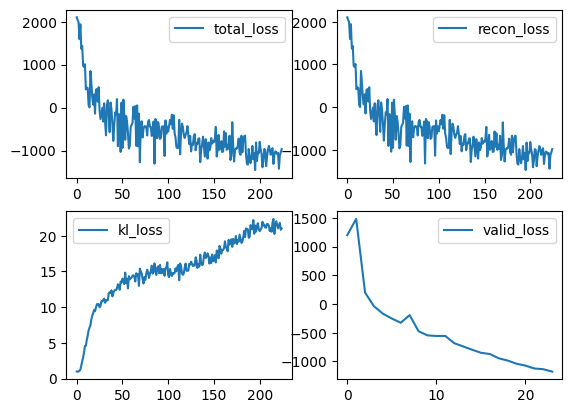

100%|██████████| 80/80 [00:26<00:00,  3.00it/s]


In [15]:
model.fit(metric, NUM_OF_COMPONENTS, edge_index)

# Evaluate

In [16]:
scores_sum, outputs, scores_argsort = model.interpret(metric, NUM_OF_COMPONENTS, edge_index, 5)

100%|██████████| 270/270 [01:31<00:00,  2.95it/s]


In [ ]:
threshold = np.percentile(scores_sum, 95)
anomalies = scores_sum > threshold

print("Anomaly Indices:", np.where(anomalies)[0])

In [18]:
# prompt: calculate f1 score
# Align the true labels with the predicted labels by selecting the relevant portion of true_anomalies
# based on the sequence_length used in the model
anomalies_len = len(anomalies) # Get the length of the predicted anomalies array
# Adjust the slicing to account for the difference in length between true_anomalies and anomalies:
# The original slicing was: true_anomalies[model.sequence_length - 1 : model.sequence_length + anomalies_len - 1]
# The issue is that model.sequence_length + anomalies_len - 1 might exceed the length of true_anomalies.
# Instead, we should ensure that the slice stays within the bounds of true_anomalies:
true_anomalies_aligned = true_anomalies[model.sequence_length - 1 : min(model.sequence_length + anomalies_len - 1, len(true_anomalies))]
# print(len(true_anomalies_aligned), anomalies_len)

# Further adjust if lengths still don't match
diff = len(anomalies) - len(true_anomalies_aligned)
if diff > 0:
  # If anomalies is longer, truncate it
  anomalies = anomalies[:-diff]
elif diff < 0:
  # If true_anomalies_aligned is longer, truncate it
  true_anomalies_aligned = true_anomalies_aligned[:diff]

# Reshape anomalies to be a 1D array of binary labels if it has multiple columns:
anomalies = anomalies.any(axis=1) # Combine predictions across columns using 'any'

f1 = f1_score(true_anomalies_aligned.ravel(),  # Ravel to make 1D
                anomalies)  # Predicted labels, now 1D

print(f"F1 Score: {f1}")

F1 Score: 0.22814814814814816
